In [6]:
import networkx as nx
import random
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
import pandas as pd

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


In [10]:

def create_dummy_topology_data(num_rings=10, nodes_per_ring=10, logical_rings_per_physical=3):
    """
    Create dummy topology data for testing
    
    Args:
        num_rings: Number of physical rings to create
        nodes_per_ring: Number of nodes per ring
        logical_rings_per_physical: Number of logical rings per physical ring
        
    Returns:
        DataFrame with topology data
    """
    data = []
    
    for pr_idx in range(num_rings):
        physical_ring = f"RING_{pr_idx}"
        block_name = f"BLOCK_{pr_idx}"  # One block per physical ring
        
        # Each physical ring has multiple logical rings from the same block
        for lr_idx in range(logical_rings_per_physical):
            logical_ring = f"LR_{pr_idx}_{lr_idx}"
            
            # Create a linear path for each logical ring (not a complete ring)
            for i in range(nodes_per_ring - 1):  # Connect nodes in a path, not a ring
                node_a = f"NODE_{pr_idx}_{lr_idx}_{i}"
                node_b = f"NODE_{pr_idx}_{lr_idx}_{i+1}"
                
                data.append({
                    'aendname': node_a,
                    'bendname': node_b,
                    'aendip': f"10.{pr_idx}.{lr_idx}.{i}",
                    'bendip': f"10.{pr_idx}.{lr_idx}.{i+1}",
                    'aendifIndex': i,
                    'bendifIndex': i+1,
                    'block_name': block_name,
                    'physicalringname': physical_ring,
                    'lrname': logical_ring
                })
            
            # Connect the first and last nodes to the block
            # First node connects to block
            data.append({
                'aendname': f"NODE_{pr_idx}_{lr_idx}_0",
                'bendname': block_name,
                'aendip': f"10.{pr_idx}.{lr_idx}.0",
                'bendip': f"10.{pr_idx}.99.99",  # Special IP for block
                'aendifIndex': 100 + lr_idx,
                'bendifIndex': 100 + lr_idx,
                'block_name': block_name,
                'physicalringname': physical_ring,
                'lrname': logical_ring
            })
            
            # Last node connects to block
            data.append({
                'aendname': f"NODE_{pr_idx}_{lr_idx}_{nodes_per_ring-1}",
                'bendname': block_name,
                'aendip': f"10.{pr_idx}.{lr_idx}.{nodes_per_ring-1}",
                'bendip': f"10.{pr_idx}.99.99",  # Special IP for block
                'aendifIndex': 200 + lr_idx,
                'bendifIndex': 200 + lr_idx,
                'block_name': block_name,
                'physicalringname': physical_ring,
                'lrname': logical_ring
            })
    
    # Add connections between blocks from different physical rings
    # for pr_idx in range(num_rings):
    #     if pr_idx < num_rings - 1:  # Connect to next physical ring
    #         # Connect this block to the next ring's block
    #         block_a = f"BLOCK_{pr_idx}"
    #         block_b = f"BLOCK_{pr_idx+1}"
            
    #         data.append({
    #             'aendname': block_a,
    #             'bendname': block_b,
    #             'aendip': f"10.{pr_idx}.99.99",
    #             'bendip': f"10.{pr_idx+1}.99.99",
    #             'aendifIndex': 300 + pr_idx,
    #             'bendifIndex': 300 + pr_idx + 1,
    #             'block_name': block_a,
    #             'physicalringname': f"RING_{pr_idx}",
    #             'lrname': "INTER_BLOCK"  # Inter-block connection
    #         })
    
    return pd.DataFrame(data)

In [11]:
topo_data = create_dummy_topology_data()

In [18]:
def build_rca_graph_from_dummy(topology_df):
    """
    Build a graph suitable for root cause analysis from dummy topology data,
    extracting pr_id and lr_id directly from node names.
    """
    G = nx.Graph()
    
    # Track nodes in each ring to assign positions later
    rings = {}
    
    # Add nodes and edges
    for _, row in topology_df.iterrows():
        aend = row['aendname']
        bend = row['bendname']
        
        # Process A-end node
        if aend.startswith("BLOCK_"):
            # Extract pr_id from block name (BLOCK_pr)
            parts = aend.split('_')
            pr_id = int(parts[1]) if len(parts) > 1 and parts[1].isdigit() else -1
            
            G.add_node(aend, 
                      ip=row['aendip'],
                      pr_id=pr_id,  # Use numeric pr_id
                      lr_id=-1,     # Blocks have no logical ring
                      position=-1,
                      is_block=True,
                      failed=0,
                      failure_time=-1)
        
        elif aend.startswith("NODE_"):
            # Extract components from node name (NODE_pr_lr_pos)
            parts = aend.split('_')
            if len(parts) >= 4:
                pr_id = int(parts[1]) if parts[1].isdigit() else -1
                lr_id = int(parts[2]) if parts[2].isdigit() else -1
                position = int(parts[3]) if parts[3].isdigit() else -1
                
                G.add_node(aend, 
                          ip=row['aendip'],
                          pr_id=pr_id,
                          lr_id=lr_id,
                          position=position,
                          is_block=False,
                          failed=0,
                          failure_time=-1)
                
                # Track nodes by ring
                ring_key = (pr_id, lr_id)
                if ring_key not in rings:
                    rings[ring_key] = set()
                rings[ring_key].add(aend)
        
        # Process B-end node with the same logic
        if bend.startswith("BLOCK_"):
            parts = bend.split('_')
            pr_id = int(parts[1]) if len(parts) > 1 and parts[1].isdigit() else -1
            
            G.add_node(bend, 
                      ip=row['bendip'],
                      pr_id=pr_id,
                      lr_id=-1,
                      position=-1,
                      is_block=True,
                      failed=0,
                      failure_time=-1)
        
        elif bend.startswith("NODE_"):
            parts = bend.split('_')
            if len(parts) >= 4:
                pr_id = int(parts[1]) if parts[1].isdigit() else -1
                lr_id = int(parts[2]) if parts[2].isdigit() else -1
                position = int(parts[3]) if parts[3].isdigit() else -1
                
                G.add_node(bend, 
                          ip=row['bendip'],
                          pr_id=pr_id,
                          lr_id=lr_id,
                          position=position,
                          is_block=False,
                          failed=0,
                          failure_time=-1)
                
                ring_key = (pr_id, lr_id)
                if ring_key not in rings:
                    rings[ring_key] = set()
                rings[ring_key].add(bend)
        
        # Add edge with attributes from row
        G.add_edge(aend, bend)
    
    print(f"Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    # Print ring statistics - now using numeric IDs
    ring_stats = {}
    for node, attrs in G.nodes(data=True):
        pr_id = attrs.get('pr_id', -1)
        lr_id = attrs.get('lr_id', -1)
        
        if isinstance(pr_id, int) and pr_id >= 0 and isinstance(lr_id, int) and lr_id >= 0:
            key = (pr_id, lr_id)
            if key not in ring_stats:
                ring_stats[key] = 0
            ring_stats[key] += 1
    
    print("\nRing statistics:")
    for ring, count in ring_stats.items():
        print(f"Ring PR={ring[0]}, LR={ring[1]}: {count} nodes")
    
    # Complete the rings by adding edges between first and last nodes
    for (pr_id, lr_id), nodes in rings.items():
        # Get nodes sorted by position
        ring_nodes = [(n, G.nodes[n]['position']) for n in nodes]
        ring_nodes.sort(key=lambda x: x[1])
        
        if len(ring_nodes) >= 2:
            # Connect first and last nodes to form a ring
            first_node = ring_nodes[0][0]
            last_node = ring_nodes[-1][0]
            
            # Don't add duplicate edges
            if not G.has_edge(first_node, last_node):
                G.add_edge(first_node, last_node)
                print(f"Added closing edge between {first_node} and {last_node}")
    
    return G

In [19]:
G = build_rca_graph_from_dummy(topo_data)

Created graph with 310 nodes and 330 edges

Ring statistics:
Ring PR=0, LR=0: 10 nodes
Ring PR=0, LR=1: 10 nodes
Ring PR=0, LR=2: 10 nodes
Ring PR=1, LR=0: 10 nodes
Ring PR=1, LR=1: 10 nodes
Ring PR=1, LR=2: 10 nodes
Ring PR=2, LR=0: 10 nodes
Ring PR=2, LR=1: 10 nodes
Ring PR=2, LR=2: 10 nodes
Ring PR=3, LR=0: 10 nodes
Ring PR=3, LR=1: 10 nodes
Ring PR=3, LR=2: 10 nodes
Ring PR=4, LR=0: 10 nodes
Ring PR=4, LR=1: 10 nodes
Ring PR=4, LR=2: 10 nodes
Ring PR=5, LR=0: 10 nodes
Ring PR=5, LR=1: 10 nodes
Ring PR=5, LR=2: 10 nodes
Ring PR=6, LR=0: 10 nodes
Ring PR=6, LR=1: 10 nodes
Ring PR=6, LR=2: 10 nodes
Ring PR=7, LR=0: 10 nodes
Ring PR=7, LR=1: 10 nodes
Ring PR=7, LR=2: 10 nodes
Ring PR=8, LR=0: 10 nodes
Ring PR=8, LR=1: 10 nodes
Ring PR=8, LR=2: 10 nodes
Ring PR=9, LR=0: 10 nodes
Ring PR=9, LR=1: 10 nodes
Ring PR=9, LR=2: 10 nodes
Added closing edge between NODE_0_0_0 and NODE_0_0_9
Added closing edge between NODE_0_1_0 and NODE_0_1_9
Added closing edge between NODE_0_2_0 and NODE_0_2_9


In [15]:
import pandas as pd
import numpy as np
import random
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination
import joblib

/home/nms/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
def generate_training_data(num_samples=5000):
    """Generate synthetic training data for root cause analysis"""
    data = []
    
    # 1. Isolated nodes with both failures (80%)
    for _ in range(int(num_samples * 0.8)):
        # Generate failure times (0.0 to 2.0)
        left_time = random.uniform(0.0, 2.0)
        right_time = random.uniform(0.0, 2.0)
        
        # Discretize times to buckets (0-9)
        left_bucket = min(9, int(left_time * 5))
        right_bucket = min(9, int(right_time * 5))
        
        # Determine root cause based on latest failure
        root_cause = 0 if left_time > right_time else 1  # 0=Left, 1=Right
        
        record = {
            'HasLeftFailure': 1,
            'HasRightFailure': 1,
            'LeftFailureTime': left_bucket,
            'RightFailureTime': right_bucket,
            'IsIsolated': 1,  # Isolated
            'RootCause': root_cause
        }
        data.append(record)
    
    # 2. Not isolated - missing left or right failure (20%)
    for _ in range(int(num_samples * 0.1)):
        right_time = random.uniform(0.0, 2.0)
        right_bucket = min(9, int(right_time * 5))
        
        record = {
            'HasLeftFailure': 0,
            'HasRightFailure': 1,
            'LeftFailureTime': 0,  # Default bucket
            'RightFailureTime': right_bucket,
            'IsIsolated': 0,  # Not isolated
            'RootCause': 1    # Right would be root
        }
        data.append(record)
    
    for _ in range(int(num_samples * 0.1)):
        left_time = random.uniform(0.0, 2.0)
        left_bucket = min(9, int(left_time * 5))
        
        record = {
            'HasLeftFailure': 1,
            'HasRightFailure': 0,
            'LeftFailureTime': left_bucket,
            'RightFailureTime': 0,  # Default bucket
            'IsIsolated': 0,  # Not isolated
            'RootCause': 0    # Left would be root
        }
        data.append(record)
    
    # Convert to DataFrame and shuffle
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    
    print(f"Generated {len(df)} training examples")
    print(f"Isolated nodes: {df['IsIsolated'].sum()} ({df['IsIsolated'].sum()/len(df)*100:.1f}%)")
    
    return df

In [2]:
def generate_training_data(num_samples=5000):
    """Generate synthetic training data for root cause analysis"""
    data = []
    
    # 1. Isolated nodes with both failures (80%)
    for _ in range(int(num_samples * 0.8)):
        # Generate failure times (0.0 to 2.0)
        left_time = random.uniform(0.0, 2.0)
        right_time = random.uniform(0.0, 2.0)
        
        # Discretize times to buckets (0-9)
        left_bucket = min(9, int(left_time * 5))
        right_bucket = min(9, int(right_time * 5))
        
        # Determine root cause based on latest failure
        root_cause = 0 if left_time > right_time else 1  # 0=Left, 1=Right
        
        record = {
            'HasLeftFailure': 1,
            'HasRightFailure': 1,
            'LeftFailureTime': left_bucket,
            'RightFailureTime': right_bucket,
            'IsIsolated': 1,  # Isolated
            'RootCause': root_cause
        }
        data.append(record)
    
    # 2. Not isolated - missing left or right failure (20%)
    for _ in range(int(num_samples * 0.1)):
        right_time = random.uniform(0.0, 2.0)
        right_bucket = min(9, int(right_time * 5))
        
        record = {
            'HasLeftFailure': 0,
            'HasRightFailure': 1,
            'LeftFailureTime': 0,  # Default bucket
            'RightFailureTime': right_bucket,
            'IsIsolated': 0,  # Not isolated
            'RootCause': 1    # Right would be root
        }
        data.append(record)
    
    for _ in range(int(num_samples * 0.1)):
        left_time = random.uniform(0.0, 2.0)
        left_bucket = min(9, int(left_time * 5))
        
        record = {
            'HasLeftFailure': 1,
            'HasRightFailure': 0,
            'LeftFailureTime': left_bucket,
            'RightFailureTime': 0,  # Default bucket
            'IsIsolated': 0,  # Not isolated
            'RootCause': 0    # Left would be root
        }
        data.append(record)
    
    # Convert to DataFrame and shuffle
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    
    print(f"Generated {len(df)} training examples")
    print(f"Isolated nodes: {df['IsIsolated'].sum()} ({df['IsIsolated'].sum()/len(df)*100:.1f}%)")
    
    return df

In [5]:
def train_rca_bayesian_network(training_data=None):
    """Create and train a Bayesian Network for RCA"""
    # If no training data provided, generate it
    if training_data is None:
        training_data = generate_training_data()
    
    # Define the network structure
    model = BayesianNetwork([
        ('HasLeftFailure', 'IsIsolated'),
        ('HasRightFailure', 'IsIsolated'),
        ('LeftFailureTime', 'RootCause'),
        ('RightFailureTime', 'RootCause')
    ])
    
    # Add CPDs with proper cardinality for all variables
    model.add_cpds(
        TabularCPD('HasLeftFailure', 2, [[0.5], [0.5]]),
        TabularCPD('HasRightFailure', 2, [[0.5], [0.5]]),
        TabularCPD('LeftFailureTime', 10, [[0.1] for _ in range(10)]),  # 10 time buckets
        TabularCPD('RightFailureTime', 10, [[0.1] for _ in range(10)])  # 10 time buckets
    )
    
    # Train the model using Bayesian estimation
    estimator = BayesianEstimator(model, training_data)
    
    # Learn CPDs for target variables
    for node in ['IsIsolated', 'RootCause']:
        try:
            cpd = estimator.estimate_cpd(node, prior_type='BDeu', equivalent_sample_size=5)
            model.add_cpds(cpd)
            print(f"Learned CPD for {node}:")
            print(cpd)
        except Exception as e:
            print(f"Error learning CPD for {node}: {e}")
    
    # Verify model is valid
    model.check_model()
    
    return model

In [3]:
def find_surrounding_failures(G, node):
    """Find the closest failures on left and right of a node in a ring"""
    
    # Get node attributes
    node_attrs = G.nodes[node]
    pr_id = node_attrs.get('pr_id', -1)
    lr_id = node_attrs.get('lr_id', -1)
    position = node_attrs.get('position', -1)
    
    # Find all failures in this ring
    ring_nodes = []
    failed_nodes = []
    
    for n, attrs in G.nodes(data=True):
        # Skip block nodes and other rings
        if attrs.get('is_block', True):
            continue
        if attrs.get('pr_id', -2) != pr_id or attrs.get('lr_id', -2) != lr_id:
            continue
        
        # Add to ring nodes
        pos = attrs.get('position', -1)
        ring_nodes.append((n, pos))
        
        # Check if failed
        if attrs.get('failed', 0) == 1:
            fail_time = attrs.get('failure_time', 0.0)
            failed_nodes.append((n, pos, fail_time))
    
    # Sort nodes by position
    ring_nodes.sort(key=lambda x: x[1])
    failed_nodes.sort(key=lambda x: x[1])
    
    # Find failures to the left and right
    left_failure = None
    right_failure = None
    
    for failed_node, failed_pos, failed_time in failed_nodes:
        if failed_pos < position:
            # This is a left failure - keep if closer than previous
            if left_failure is None or failed_pos > left_failure[1]:
                left_failure = (failed_node, failed_pos, failed_time)
        elif failed_pos > position:
            # This is a right failure - keep if closer than previous
            if right_failure is None or failed_pos < right_failure[1]:
                right_failure = (failed_node, failed_pos, failed_time)
    
    return left_failure, right_failure

In [4]:
def predict_root_cause(model, G, node):
    """Predict root cause for a given node using the trained BN model"""
    
    # Find failures surrounding this node
    left_failure, right_failure = find_surrounding_failures(G, node)
    
    # Prepare evidence for the Bayesian network
    evidence = {
        'HasLeftFailure': 1 if left_failure else 0,
        'HasRightFailure': 1 if right_failure else 0
    }
    
    # If we have failures on both sides, add time evidence
    if left_failure and right_failure:
        # Extract and discretize failure times
        left_time = left_failure[2]
        right_time = right_failure[2]
        
        # Convert to buckets (0-9)
        left_bucket = min(9, int(left_time * 5))
        right_bucket = min(9, int(right_time * 5))
        
        evidence['LeftFailureTime'] = left_bucket
        evidence['RightFailureTime'] = right_bucket
    
    # Create inference engine
    inference = VariableElimination(model)
    
    # Query if node is isolated
    isolation_result = inference.query(['IsIsolated'], evidence=evidence)
    is_isolated = isolation_result.values[1] > 0.5 if len(isolation_result.values) > 1 else False
    
    if not is_isolated:
        print(f"Node {node} is not isolated between failures")
        return None
    
    # If isolated, query for root cause
    root_cause_result = inference.query(['RootCause'], evidence=evidence)
    
    # Get most likely root cause (0=left, 1=right)
    root_probs = root_cause_result.values
    root_idx = np.argmax(root_probs)
    probability = root_probs[root_idx]
    
    # Map back to actual nodes
    if root_idx == 0 and left_failure:  # Left is root
        root_node = left_failure[0]
        root_time = left_failure[2]
    elif right_failure:  # Right is root
        root_node = right_failure[0]
        root_time = right_failure[2]
    else:
        root_node = None
        root_time = None
    
    # Print results
    print(f"Node {node} is isolated between:")
    if left_failure:
        print(f"  Left: {left_failure[0]} (time: {left_failure[2]:.2f})")
    else:
        print("  Left: None")
        
    if right_failure:
        print(f"  Right: {right_failure[0]} (time: {right_failure[2]:.2f})")
    else:
        print("  Right: None")
    
    if root_node:
        print(f"Root cause: {root_node} with probability {probability:.4f}")
        print(f"Root is {'left' if root_idx == 0 else 'right'} failure")
    else:
        print("No root cause identified")
    
    return {
        'node': node,
        'is_isolated': is_isolated,
        'left_failure': left_failure[0] if left_failure else None,
        'right_failure': right_failure[0] if right_failure else None,
        'left_time': left_failure[2] if left_failure else None,
        'right_time': right_failure[2] if right_failure else None,
        'root_cause': root_node,
        'root_time': root_time,
        'root_side': 'left' if root_idx == 0 else 'right',
        'probability': probability
    }

In [22]:
H = G.copy()
H.nodes["NODE_0_0_2"]['failed'] = 1
H.nodes["NODE_0_0_2"]['failure_time'] = 0.3  # Earlier

H.nodes["NODE_0_0_7"]['failed'] = 1
H.nodes["NODE_0_0_7"]['failure_time'] = 0.7  # Later, should be root cause

# Option 1: Train a model and analyze a specific node
bn_model = train_rca_bayesian_network()
result = predict_root_cause(bn_model, H, "NODE_0_0_4")

Generated 5000 training examples
Isolated nodes: 4000 (80.0%)
Learned CPD for IsIsolated:
+-----------------+-----+------------------------+
| HasLeftFailure  | ... | HasLeftFailure(1)      |
+-----------------+-----+------------------------+
| HasRightFailure | ... | HasRightFailure(1)     |
+-----------------+-----+------------------------+
| IsIsolated(0)   | ... | 0.00015620118712902218 |
+-----------------+-----+------------------------+
| IsIsolated(1)   | ... | 0.999843798812871      |
+-----------------+-----+------------------------+
Learned CPD for RootCause:
+------------------+-----+---------------------+
| LeftFailureTime  | ... | LeftFailureTime(9)  |
+------------------+-----+---------------------+
| RightFailureTime | ... | RightFailureTime(9) |
+------------------+-----+---------------------+
| RootCause(0)     | ... | 0.4865047233468286  |
+------------------+-----+---------------------+
| RootCause(1)     | ... | 0.5134952766531714  |
+------------------+-----+------

In [23]:
# Print all CPDs in the trained model
print("\nAll CPDs in the Bayesian Network:")
for i, cpd in enumerate(bn_model.cpds):
    print(f"\nCPD #{i+1}: {cpd.variable}")
    print(cpd)


All CPDs in the Bayesian Network:

CPD #1: HasLeftFailure
+-------------------+-----+
| HasLeftFailure(0) | 0.5 |
+-------------------+-----+
| HasLeftFailure(1) | 0.5 |
+-------------------+-----+

CPD #2: HasRightFailure
+--------------------+-----+
| HasRightFailure(0) | 0.5 |
+--------------------+-----+
| HasRightFailure(1) | 0.5 |
+--------------------+-----+

CPD #3: LeftFailureTime
+--------------------+-----+
| LeftFailureTime(0) | 0.1 |
+--------------------+-----+
| LeftFailureTime(1) | 0.1 |
+--------------------+-----+
| LeftFailureTime(2) | 0.1 |
+--------------------+-----+
| LeftFailureTime(3) | 0.1 |
+--------------------+-----+
| LeftFailureTime(4) | 0.1 |
+--------------------+-----+
| LeftFailureTime(5) | 0.1 |
+--------------------+-----+
| LeftFailureTime(6) | 0.1 |
+--------------------+-----+
| LeftFailureTime(7) | 0.1 |
+--------------------+-----+
| LeftFailureTime(8) | 0.1 |
+--------------------+-----+
| LeftFailureTime(9) | 0.1 |
+--------------------+----

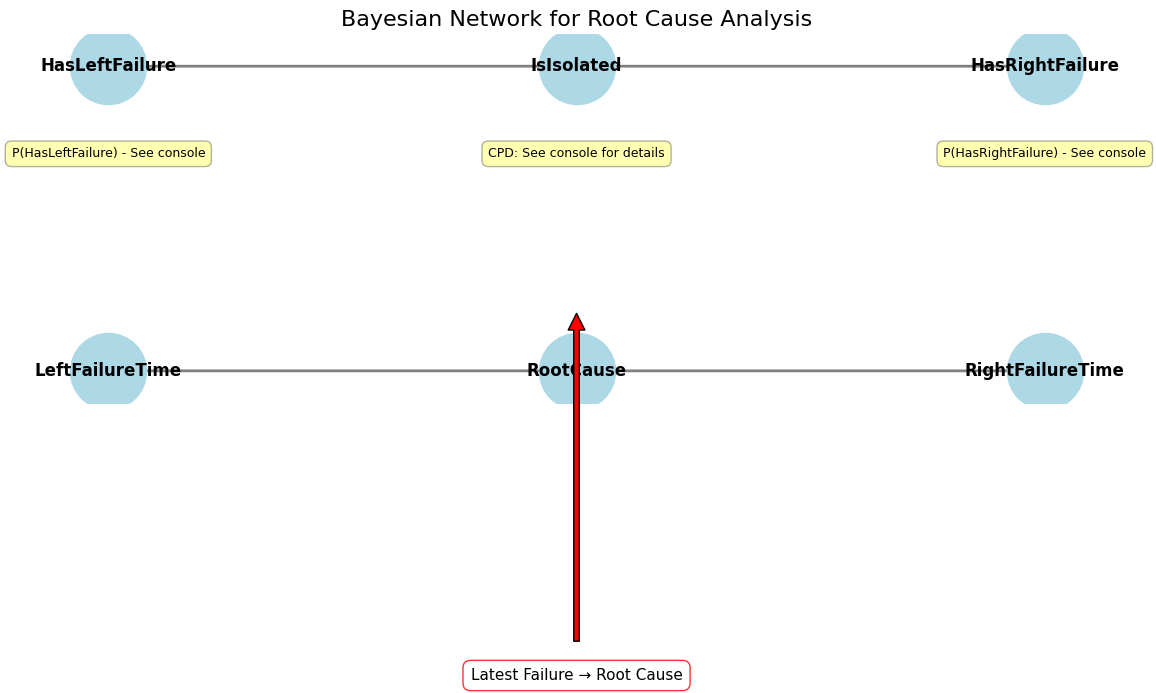

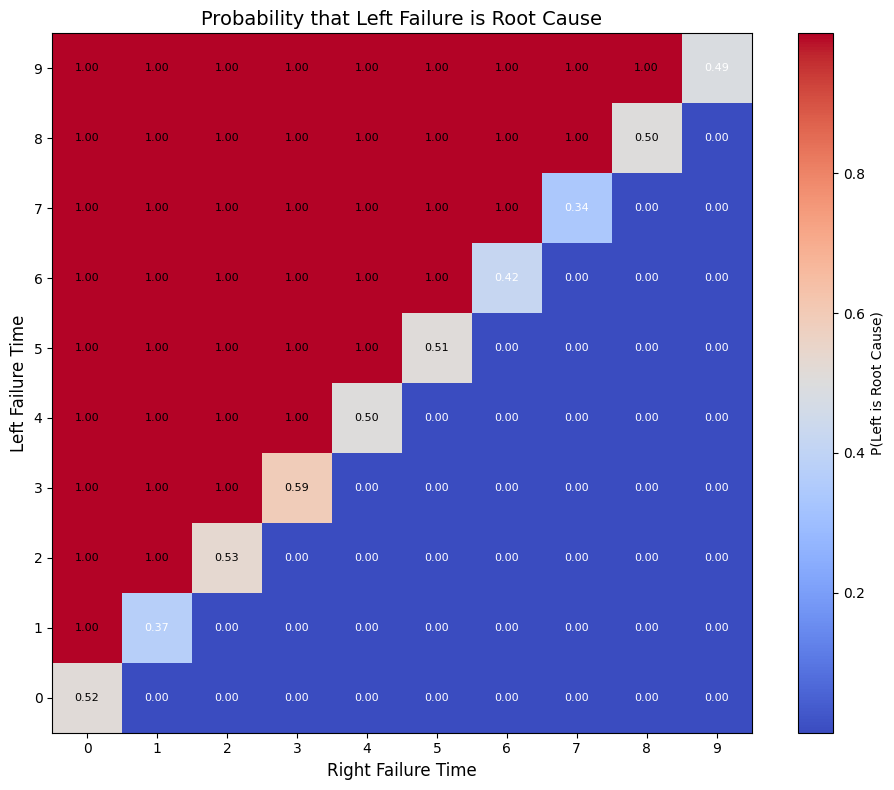

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import numpy as np

def visualize_bayesian_network(model):
    """
    Create a visualization of a Bayesian Network showing:
    1. Nodes and their relationships
    2. Key probability values
    """
    # Create a directed graph from the BN structure
    G = nx.DiGraph()
    
    # Add nodes and edges from the Bayesian Network
    for node in model.nodes():
        G.add_node(node)
    
    for edge in model.edges():
        G.add_edge(edge[0], edge[1])
    
    # Create plot
    plt.figure(figsize=(12, 10))
    
    # Define node positions (you can adjust this layout for better visualization)
    pos = {
        'HasLeftFailure': (-2, 0),
        'HasRightFailure': (2, 0),
        'LeftFailureTime': (-2, -2),
        'RightFailureTime': (2, -2),
        'IsIsolated': (0, 0),
        'RootCause': (0, -2)
    }
    
    # Draw nodes with labels
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=3000)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    
    # Draw edges with arrows
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, width=2, edge_color='gray')
    
    # Add probability annotations for each node
    for node in model.nodes():
        cpd = model.get_cpds(node)
        
        try:
            # Create a simplified probability annotation
            if node == 'IsIsolated':
                # For IsIsolated, show P(IsIsolated=1|Left=1,Right=1)
                values = cpd.values
                # Check if the shape is as expected
                if values.shape[1] > 3:  # Make sure we have enough columns
                    p_isolated = values[1][3]  # P(IsIsolated=1|HasLeft=1,HasRight=1)
                    prob_text = f"P(Isolated=1|Left=1,Right=1) = {p_isolated:.3f}"
                else:
                    prob_text = "CPD: See console for details"
            
            elif node == 'RootCause':
                # For RootCause, show probabilities for a few cases
                values = cpd.values
                if len(cpd.variables) >= 3:  # Make sure we have time variables
                    # Case: Left time > Right time
                    lt_idx = cpd.variables.index('LeftFailureTime') - 1
                    rt_idx = cpd.variables.index('RightFailureTime') - 1
                    
                    evidence1 = [0] * (len(cpd.variables) - 1)
                    evidence1[lt_idx] = 9  # High left time
                    evidence1[rt_idx] = 0  # Low right time
                    p_left_high = values[0][tuple(evidence1)]
                    
                    evidence2 = [0] * (len(cpd.variables) - 1)
                    evidence2[lt_idx] = 0  # Low left time
                    evidence2[rt_idx] = 9  # High right time
                    p_left_low = values[0][tuple(evidence2)]
                    
                    prob_text = f"P(Left=Root|LT=9,RT=0) = {p_left_high:.2f}\nP(Left=Root|LT=0,RT=9) = {p_left_low:.2f}"
                else:
                    prob_text = "Complex CPD"
            
            else:
                # For other nodes with simpler distributions
                # Check the shape of values to handle different structures
                if isinstance(cpd.values, np.ndarray):
                    if cpd.values.ndim > 1 and cpd.values.shape[0] > 1:
                        prob_text = f"P({node}=1) = {cpd.values[1][0]:.2f}"
                    else:
                        prob_text = f"P({node}) - See console"
                else:
                    prob_text = f"P({node}) - See console"
            
            # Position the text below the node
            x, y = pos[node]
            plt.annotate(
                prob_text,
                xy=(x, y-0.35),
                xytext=(0, -20),
                textcoords='offset points',
                ha='center',
                va='top',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3),
                fontsize=9
            )
            
        except Exception as e:
            print(f"Error creating annotation for {node}: {e}")
            # Add a simpler annotation
            x, y = pos[node]
            plt.annotate(
                f"{node}\n(See console for details)",
                xy=(x, y-0.35),
                xytext=(0, -20),
                textcoords='offset points',
                ha='center',
                va='top',
                bbox=dict(boxstyle='round,pad=0.5', fc='pink', alpha=0.3),
                fontsize=9
            )
    
    # Add labels and title
    plt.axis('off')
    plt.title('Bayesian Network for Root Cause Analysis', fontsize=16)
    
    # Highlight special relationships with annotations
    plt.annotate(
        "Latest Failure → Root Cause",
        xy=(0, -1.5),
        xytext=(0, -4),
        arrowprops=dict(facecolor='red', shrink=0.05),
        ha='center',
        va='center',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='red', alpha=0.8),
        fontsize=11
    )
    
    plt.tight_layout()
    plt.show()

    # Create a heat map for RootCause probabilities
    show_root_cause_heatmap(model)
    
def show_root_cause_heatmap(model):
    """Show a heatmap of root cause probabilities based on failure times"""
    try:
        cpd = model.get_cpds('RootCause')
        
        # Check if we have the expected variables
        if 'LeftFailureTime' in cpd.variables and 'RightFailureTime' in cpd.variables:
            # Get indices of time variables
            lt_idx = cpd.variables.index('LeftFailureTime') - 1
            rt_idx = cpd.variables.index('RightFailureTime') - 1
            
            # Create a matrix for the heatmap - P(Left is root)
            matrix = np.zeros((10, 10))
            
            # Fill the matrix with probabilities
            for lt in range(10):
                for rt in range(10):
                    evidence = [0] * (len(cpd.variables) - 1)
                    evidence[lt_idx] = lt
                    evidence[rt_idx] = rt
                    
                    # Get P(Left is root) = P(RootCause=0)
                    matrix[lt, rt] = cpd.values[0][tuple(evidence)]
            
            # Create heatmap plot
            plt.figure(figsize=(10, 8))
            
            # Plot heatmap
            plt.imshow(matrix, cmap='coolwarm', origin='lower')
            plt.colorbar(label='P(Left is Root Cause)')
            
            # Add grid lines
            plt.grid(False)
            
            # Add labels
            plt.xlabel('Right Failure Time', fontsize=12)
            plt.ylabel('Left Failure Time', fontsize=12)
            plt.title('Probability that Left Failure is Root Cause', fontsize=14)
            
            # Set axis ticks
            plt.xticks(np.arange(10), labels=range(10))
            plt.yticks(np.arange(10), labels=range(10))
            
            # Add annotations
            for i in range(10):
                for j in range(10):
                    plt.text(j, i, f'{matrix[i, j]:.2f}', 
                            ha="center", va="center", 
                            color="white" if matrix[i, j] < 0.5 else "black",
                            fontsize=8)
            
            plt.tight_layout()
            plt.show()
        
    except Exception as e:
        print(f"Couldn't create heatmap: {e}")

# Call the visualization function
visualize_bayesian_network(bn_model)